`RandomForestRegressor` is a machine learning algorithm for regression tasks provided by the scikit-learn library. Here's a brief description:

Random Forest Regressor:

- **Ensemble Method:** RandomForestRegressor is an ensemble learning method, meaning it combines the predictions of multiple individual models to produce a more robust and accurate overall prediction.

- **Decision Trees:** The base models in a random forest are decision trees. Each tree is constructed independently, and during the training process, each tree is provided with a random subset of the training data and a random subset of features for making decisions.

- **Bagging:** Random Forest uses a technique called bagging (Bootstrap Aggregating) to train multiple trees. It involves creating random subsets of the training data by sampling with replacement (bootstrapping). Each tree is trained on a different subset.

- **Random Feature Selection:** In addition to using different subsets of data, each tree is trained on a random subset of features at each split. This helps in decorrelating the trees and making the ensemble more robust.

- **Prediction:** The final prediction of the random forest is the average (for regression) of the predictions of its individual trees.

- **Robust to Overfitting:** Random Forests tend to be resistant to overfitting, as the individual trees may overfit the training data, but the ensemble combines their predictions in a way that mitigates this.

- **Versatility:** RandomForestRegressor can handle both numerical and categorical features, and it requires minimal hyperparameter tuning.

In summary, RandomForestRegressor is a powerful and versatile algorithm for regression tasks, known for its robustness, flexibility, and ability to handle complex relationships in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import requests
import seaborn as sns

# Replace 'YOUR_OPENWEATHERMAP_API_KEY' with your actual API key
api_key = '4a6f678accaa56032e7faf5a0236af32'
city = 'ovar'
country = 'portugal'
lat = '40.85'
lon = '-8.62'
cnt = 7
start_date = datetime(2024, 1, 30)   # Replace with your desired start date

# Function to get weather data from OpenWeatherMap API
def get_weather_data(api_key, city='ovar', country='portugal'):
    base_url = 'http://api.openweathermap.org/data/2.5/forecast'
    params = {
        'q': f'{city},{country}',
        'appid': api_key,
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    #print(data)
    return data



In [2]:
# Function to get forecasted sunrise and sunset times from an API for each day
def get_sunrise_sunset_forecast(num_days):
    forecasted_sunrise_times = []
    forecasted_sunset_times = []

    for day in range(num_days):
        date = start_date + timedelta(days=day)
        timestamp = int(date.timestamp())
        api_url = f'http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&dt={timestamp}&units=imperial&appid={api_key}'
        response = requests.get(api_url)
        data = response.json()

        # Extracting sunrise and sunset times
        sunrise_time = pd.to_datetime(data['sys']['sunrise'], unit='s')
        sunset_time = pd.to_datetime(data['sys']['sunset'], unit='s')

        forecasted_sunrise_times.append(sunrise_time)
        forecasted_sunset_times.append(sunset_time)

    return forecasted_sunrise_times, forecasted_sunset_times

# Function to predict future sunlight durations using forecasted sunrise and sunset times
def predict_future_sunlight_duration(num_days=7):
    forecasted_sunrise_times, forecasted_sunset_times = get_sunrise_sunset_forecast(num_days)

    # Calculate forecasted sunlight durations
    forecasted_sunlight_durations = (pd.Series(forecasted_sunset_times) - pd.Series(forecasted_sunrise_times)).dt.total_seconds() / 3600.0

    # Assuming a simple prediction model (mean of forecasted durations)
    predicted_sunlight_durations = [forecasted_sunlight_durations.mean()] * num_days

    return predicted_sunlight_durations

# Function to get the last 7 days' energy produced
def get_last_7_days_energy(start_date, num_days):
    # Replace this with your actual method to retrieve the last 7 days' energy data
    # For demonstration, using random values
    return np.random.randint(80, 150, num_days)

{'cod': '200', 'message': 0, 'cnt': 40, 'list': [{'dt': 1762527600, 'main': {'temp': 291.04, 'feels_like': 291.21, 'temp_min': 290.79, 'temp_max': 291.04, 'pressure': 1014, 'sea_level': 1014, 'grnd_level': 1010, 'humidity': 89, 'temp_kf': 0.25}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10d'}], 'clouds': {'all': 60}, 'wind': {'speed': 5.09, 'deg': 310, 'gust': 7.03}, 'visibility': 10000, 'pop': 0.79, 'rain': {'3h': 0.5}, 'sys': {'pod': 'd'}, 'dt_txt': '2025-11-07 15:00:00'}, {'dt': 1762538400, 'main': {'temp': 289.23, 'feels_like': 289.14, 'temp_min': 288.26, 'temp_max': 289.23, 'pressure': 1016, 'sea_level': 1016, 'grnd_level': 1011, 'humidity': 86, 'temp_kf': 0.97}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'clouds': {'all': 51}, 'wind': {'speed': 4.81, 'deg': 301, 'gust': 7.34}, 'visibility': 10000, 'pop': 0.64, 'rain': {'3h': 0.24}, 'sys': {'pod': 'n'}, 'dt_txt': '2025-11-07 18:00:00'}, {'dt': 176254920

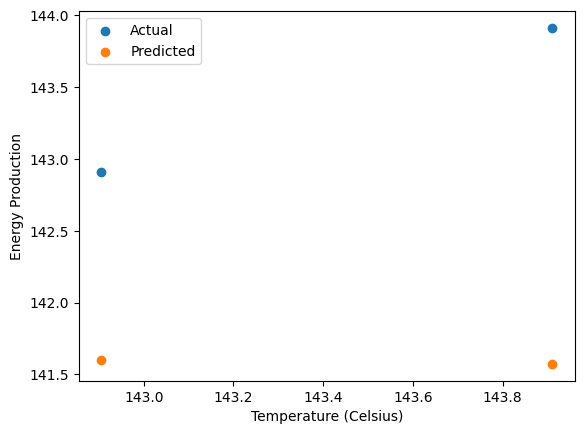

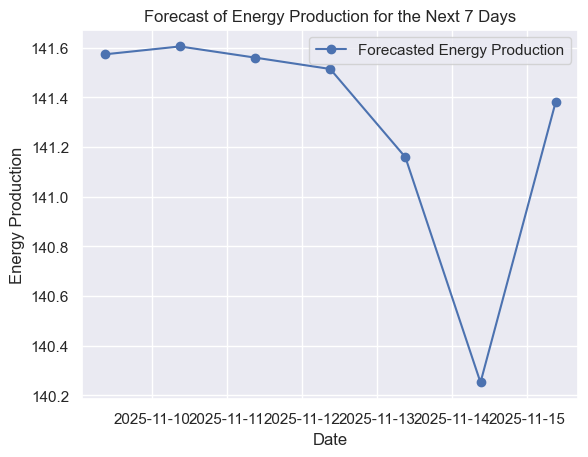

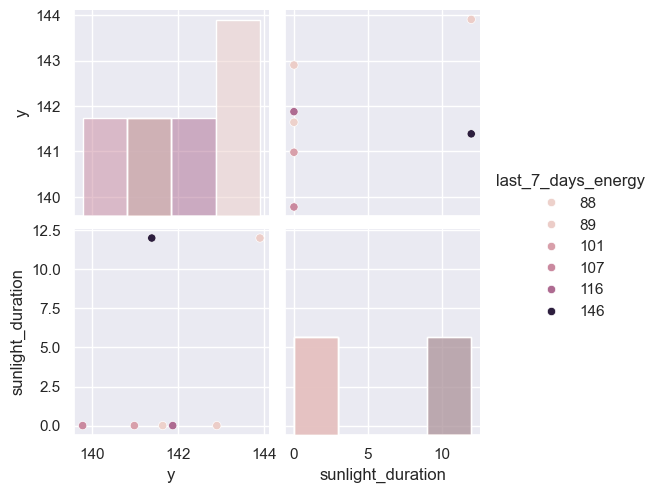

In [3]:
last_7_days_energy = get_last_7_days_energy(start_date, 7)

# Example: Get weather data for the next 7 days
weather_data = get_weather_data(api_key)
daily_forecasts = weather_data.get('list', [])[:7]

# Extracting temperature information (converting to Celsius)
temperature_forecast = [(forecast['main']['temp'] - 32) * 5/9 for forecast in daily_forecasts]

# Extracting the information needed for sunlight duration
sunlight_duration = [12 if 'd' in forecast['sys']['pod'] else 0 for forecast in daily_forecasts]

# Generate a simplified DataFrame with 'ds', 'y', 'sunlight_duration', and 'last_7_days_energy' columns
data = pd.DataFrame({
    'ds': pd.to_datetime([forecast['dt_txt'] for forecast in daily_forecasts]),
    'y': temperature_forecast,
    'sunlight_duration': sunlight_duration,
    'last_7_days_energy': last_7_days_energy,
})


# Ensure all arrays have the same length
if len(set(map(len, [data['ds'], data['y'], data['sunlight_duration'], data['last_7_days_energy']]))) != 1:
    raise ValueError("All arrays must be of the same length")

# Create features and target
X = data[['y', 'sunlight_duration', 'last_7_days_energy']]
y = data['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the actual vs predicted values
plt.scatter(X_test['y'], y_test, label='Actual')
plt.scatter(X_test['y'], y_pred, label='Predicted')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

# Forecast the next 7 days
future_sunlight_duration = predict_future_sunlight_duration()
future_temperature = [(forecast['main']['temp'] - 32) * 5/9 for forecast in daily_forecasts]
# Meter values mock
future_last_7_days_energy = get_last_7_days_energy(data['ds'].max(), 7)

# Create a future DataFrame for prediction
future_data = pd.DataFrame({
    'y': future_temperature,
    'sunlight_duration': future_sunlight_duration,
    'last_7_days_energy': future_last_7_days_energy,
})

# Make predictions for the next 7 days
future_energy_forecast = rf_model.predict(future_data)

sns.set()
# Plot the forecast with calendar dates on x-axis
future_dates = pd.date_range(data['ds'].max() + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, future_energy_forecast, marker='o', label='Forecasted Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.title('Forecast of Energy Production for the Next 7 Days')
plt.legend()
plt.show()

sns.pairplot(data, height=2.5, hue="last_7_days_energy", diag_kind="hist");
